In [ ]:
!git clone https://github.com/ultralytics/yolov5

In [ ]:
!pip install -r yolov5/requirements.txt

In [7]:
import torch
from IPython.display import Image  # for displaying images
import os, glob 
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

random.seed(108)

In [ ]:
!wget https://www.dropbox.com/s/pyjdiq0vhdfgq8a/voc.zip
!unzip voc.zip

In [10]:
# Function to get the data from XML Annotation
def extract_info_from_xml(xml_file):
    root = ET.parse(xml_file).getroot()
    
    # Initialise the info dict 
    info_dict = {}
    info_dict['bboxes'] = []

    # Parse the XML Tree
    for elem in root:
        # Get the file name 
        if elem.tag == "filename":
            info_dict['filename'] = elem.text
            
        # Get the image size
        elif elem.tag == "size":
            image_size = []
            for subelem in elem:
                image_size.append((subelem.text))
            
            info_dict['image_size'] = tuple(image_size)
        
        # Get details of the bounding box 
        elif elem.tag == "object":
            bbox = {}
            for subelem in elem:
                if subelem.tag == "name":
                    bbox["class"] = subelem.text
                    
                elif subelem.tag == "bndbox":
                    for subsubelem in subelem:
                        bbox[subsubelem.tag] = (subsubelem.text)            
            info_dict['bboxes'].append(bbox)
    
    return info_dict


In [11]:
# Dictionary that maps class names to IDs
class_name_to_id_mapping = {"ned_p_v": 0}

# Convert the info dict to the required yolo format and write it to disk
def convert_to_yolov5(info_dict):
    print_buffer = []
    
    # For each bounding box
    for b in info_dict["bboxes"]:
        try:
            class_id = class_name_to_id_mapping[b["class"]]
        except KeyError:
            print("Invalid Class. Must be one from ", class_name_to_id_mapping.keys())
        
        # Transform the bbox co-ordinates as per the format required by YOLO v5
        b_center_x = int((float(b["xmin"]) + float(b["xmax"])) / 2 )
        b_center_y = int((float(b["ymin"]) + float(b["ymax"])) / 2)
        b_width    = int((float(b["xmax"]) - float(b["xmin"])))
        b_height   = int((float(b["ymax"]) - float(b["ymin"])))
        str
        # Normalise the co-ordinates by the dimensions of the image
        image_w, image_h, image_c = info_dict["image_size"]  
        b_center_x /= int(image_w) 
        b_center_y /= int(image_h) 
        b_width    /= int(image_w) 
        b_height   /= int(image_h) 
        
        #Write the bbox details to the file 
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))
        
    # Name of the file which we have to save 
    save_file_name = os.path.join("/content/voc07/Annotations", info_dict["filename"].replace("xml", "txt"))
    
    # Save the annotation to disk
    print("\n".join(print_buffer), file= open(save_file_name, "w"))

In [ ]:
# Get the annotations
annotations = [os.path.join('/content/voc07/Annotations', x) for x in os.listdir('/content/voc07/Annotations') if x[-3:] == "xml"]
annotations.sort()

# Convert and save the annotations
for ann in tqdm(annotations):
    info_dict = extract_info_from_xml(ann)
    convert_to_yolov5(info_dict)
annotations = [os.path.join('/content/voc07/Annotations', x) for x in os.listdir('/content/voc07/Annotations') if x[-3:] == "txt"]

In [13]:
os.chdir('/content/voc07/Annotations/')
for file in glob.glob('*.jpg'):
  file_name = file
  file_name_array=file_name.split('.')
  new_file_name = file_name_array[0]+'.txt'
  os.system('cp /content/voc07/Annotations/'+file_name+' /content/voc07/Annotations/'+new_file_name)

In [14]:
os.chdir('/content/voc07/Annotations/')
for file in glob.glob('*.jpg'):
  file_name = file
  os.system('rm /content/voc07/Annotations/'+file_name)

In [16]:
# Read images and annotations
images = [os.path.join('/content/voc07/JPEGImages', x) for x in os.listdir('/content/voc07/JPEGImages')]
annotations = [os.path.join('/content/voc07/Annotations/', x) for x in os.listdir('/content/voc07/Annotations/') if x[-3:] == "txt"]

images.sort()
annotations.sort()

# Split the dataset into train-valid-test splits 
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)

In [17]:
!mkdir /content/voc07/JPEGImages/train /content/voc07/JPEGImages/val /content/voc07/JPEGImages/test /content/voc07/Annotations/train /content/voc07/Annotations/val /content/voc07/Annotations/test

In [18]:
#Utility function to move images 
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.move(f, destination_folder)
        except:
            print(f)
            assert False

# Move the splits into their folders
move_files_to_folder(train_images, '/content/voc07/JPEGImages/train')
move_files_to_folder(val_images, '/content/voc07/JPEGImages/val/')
move_files_to_folder(test_images, '/content/voc07/JPEGImages/test/')
move_files_to_folder(train_annotations, '/content/voc07/Annotations/train/')
move_files_to_folder(val_annotations, '/content/voc07/Annotations/val/')
move_files_to_folder(test_annotations, '/content/voc07/Annotations/test/')

In [19]:
!mv /content/voc07/Annotations /content/labels
!mv /content/voc07/JPEGImages/ /content/images
!cd /content/yolov5 

In [ ]:
!python /content/yolov5/train.py --img 1024 --cfg yolov5s.yaml --hyp /content/yolov5/data/hyps/hyp.Objects365.yaml --batch 32 --epochs 300 --data polygons_data.yaml --weights yolov5x.pt --workers 128 --name yolo_polygon_det

In [ ]:
!python /content/yolov5/detect.py --source /content/images/test/ --weights /content/yolov5/runs/train/yolo_polygon_det/weights/best.pt --conf 0.25 --name yolo_polygon_det

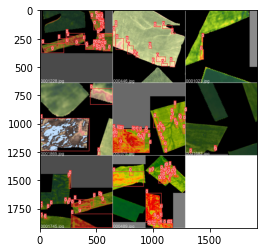

In [ ]:
detections_dir = "/content/yolov5/runs/train/yolo_polygon_det"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

random_detection_image = Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))

In [ ]:
!python /content/yolov5/val.py --weights /content/yolov5/runs/train/yolo_polygon_det/weights/best.pt --data polygons_data.yaml --task test --name yolo_polygon_det